# PyTorch et WaveNet


Dans ce cours, nous nous inspirons de l'architecture du modèle [WaveNet](https://deepmind.google/discover/blog/wavenet-a-generative-model-for-raw-audio/) proposée par Google DeepMind pour le traitement de l'audio. Notre objectif est d'utiliser un plus grand nombre de caractères pour le contexte de notre prédicteur du prochain mot.


## Architecture


L'architecture d'un WaveNet est une architecture hiérarchique qui accorde plus de poids aux éléments de contexte les plus proches.

Voici à quoi ressemble l'architecture :

![WaveNet](./images/wavenet.png)

Figure extraite de l'article original.


## Implémentation du modèle fully connected avec PyTorch


Le cours commence par une adaptation des concepts du cours précédent en utilisant les fonctions de PyTorch.


### Dataset


Reprenons le code du notebook précédent pour la génération du dataset.


In [38]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from torch.utils.data import TensorDataset, DataLoader, random_split

%matplotlib inline

In [39]:
# Lecture du dataset
words = open('prenoms.txt', 'r').read().splitlines()
print(words[:8])

['MARIE', 'JEAN', 'PIERRE', 'MICHEL', 'ANDRÉ', 'JEANNE', 'PHILIPPE', 'LOUIS']


In [40]:
words = open('prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

Pour changer, augmentons le contexte en le passant de 3 à 8. Cela nous donnera un indicateur de performance car nous utiliserons aussi 8 pour notre WaveNet.


In [41]:
block_size = 8 # La longueur du contexte, combien de caractères pour prédire le suivant ?
X, Y = [], []
for k,w in enumerate(words):
  
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] 
X = torch.tensor(X)
Y = torch.tensor(Y)

In [42]:
dataset=TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(TensorDataset(X, Y),[train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Création du modèle et entraînement


Pour commencer, nous allons réimplementer le modèle du notebook précédent, mais avec PyTorch.


In [43]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [44]:
class fcn(nn.Module):
  def __init__(self,embed_dim=10,context_len=8,hidden_dim=300, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.embed_dim=embed_dim
    self.context_len=context_len
    
    #La fonction nn.Embedding de pytorch est l'équivalent de la matrice C 
    self.embedding=nn.Embedding(46,embed_dim)
    self.layer1=nn.Linear(embed_dim*context_len,hidden_dim)
    self.layer2=nn.Linear(hidden_dim,46)

  def forward(self,x):       
    embed=self.embedding(x) # Remplace la matrice C
    embed=embed.view(-1,self.embed_dim*self.context_len)
    hidden=F.tanh(self.layer1(embed))
    logits=self.layer2(hidden)
    return logits


In [45]:
model=fcn(context_len=8)
epochs=50
lr=0.2
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
for p in model.parameters():
  p.requires_grad = True

**Notes** : Pour reproduire à l'identique le code du notebook précédent, il faudra réduire le *learning rate* par un facteur 10 à la moitié de l'entraînement. En PyTorch, on peut faire ça à l'aide du [*scheduler*](https://pytorch.org/docs/stable/optim.html). Il existe plusieurs types de *scheduler* : *LambdaLR* (pour changer le *learning rate* par rapport à une fonction), *StepLR* (pour diminuer le *learning rate* toutes les *n* epochs), *LinearLR* (pour diminuer le *learning rate* de manière linéaire), *ReduceLROnPlateau* (pour diminuer le *learning rate* dès que le *loss* ne change plus), *OneCycleLR* (pour commencer avec un *learning rate* faible puis l'augmenter et le redescendre) et bien d'autres.

Pour accélérer la convergence d'un modèle, je vous conseillerais l'utilisation du *OneCycleLR* (pour en savoir plus, consultez ce [blogpost](https://www.datacamp.com/tutorial/cyclical-learning-neural-nets)). Pour obtenir un modèle très performant, je vous conseillerais plutôt le *ReduceLROnPlateau*. Dans tous les cas, il est intéressant d'expérimenter vous-même avec les différents *scheduler*.


In [46]:
lossi=[]
lossvali=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    # forward pass
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    # retropropagation
    optimizer.zero_grad()
    loss.backward()
    # Mise à jour des poids du modèle
    optimizer.step()
    loss_epoch+=loss
  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  
  # Validation
  loss_val=0
  for x,y in val_loader:
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")

Epoch 0 - Training loss: 2.487, Validation loss: 2.427
Epoch 10 - Training loss: 2.056, Validation loss: 2.151
Epoch 20 - Training loss: 1.952, Validation loss: 2.114
Epoch 30 - Training loss: 1.896, Validation loss: 2.146
Epoch 40 - Training loss: 1.864, Validation loss: 2.092


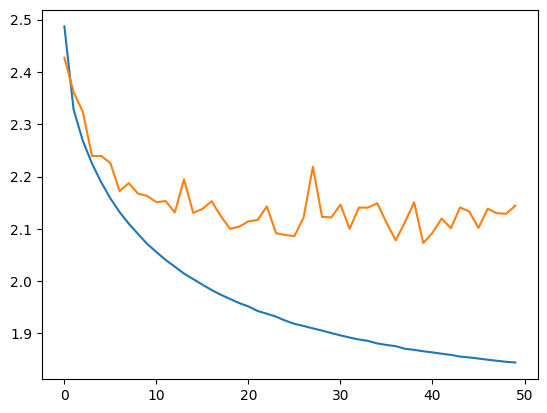

In [47]:
plt.plot(stepi, lossi)
plt.plot(stepi,lossvali)

La différence entre la courbe de training et de validation indique que le modèle *overfit* un peu.


In [48]:
# On annule le calcul des gradients car on n'est plus en phase d'entraînement.
model.eval()
loss_test=0
for x,y in test_loader:
    
  # forward pass
  logits=model(x)
  loss = F.cross_entropy(logits, y)
      
  loss_test+=loss
loss_test=loss_test/len(test_loader)
print(loss_test)

tensor(2.1220, grad_fn=<DivBackward0>)


Le *loss* de test est un peu supérieur au *loss* de train, donc le modèle a un peu *overfit*, mais ça reste léger et on a encore de la marge pour augmenter les capacités du réseau. On peut maintenant vérifier la qualité de la génération de prénoms.


In [49]:
for _ in range(5):
  out = []
  context = [0] * block_size 
  while True:
    logits=model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

LOUIS-ANDRÉ.
YOHES.
BRES.
TERIGAND.
CONKHE.


Les prénoms générés sont corrects, mais améliorables. Voyons voir si on peut obtenir un meilleur *loss* sur les données de test avec l'approche WaveNet.


## Implémentation du WaveNet avec PyTorch


Le dataset est le même que pour la partie précédente, pas besoin de changer quoi que ce soit.


### Comment gérer l'architecture hiérarchique


Ce qu'on veut dans notre modèle, c'est traiter en parallèle des groupes d'*embedding* en regroupant les caractères consécutifs. Sur PyTorch, si on fait passer un tenseur de taille $B \times L \times C$ dans une couche linéaire de taille $C \times H$, on obtient un tenseur de taille $B \times L \times H$, et c'est exactement ce que l'on veut pour implémenter le réseau WaveNet.


Maintenant, il faut trouver comment modifier la taille du tenseur pour faire les opérations du WaveNet. Nos 8 *embedding* sont regroupés par deux puis traités en parallèle. À la couche suivante, ils sont à nouveau regroupés par deux. Donc à chaque étape, on double la taille $H$ (ou $C$) et on divise par deux $L$.

Pour être plus clair, à la première étape, nous avons un tenseur de taille $B \times 8 \times 10$ que l'on veut transformer en tenseur de taille $B \times 4 \times 20$. On peut implémenter ça avec [*view()*](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html) de PyTorch.


In [50]:
dummy=torch.randn([256,8,10])
# On divise par deux L et on double H/C
dummy=dummy.view(-1,dummy.shape[1]//2,dummy.shape[2]*2)
print(dummy.shape)

torch.Size([256, 4, 20])


Essayons de formaliser ça avec une couche que l'on pourra utiliser dans notre réseau :


In [51]:
class FlattenConsecutive(nn.Module):
  # n est le facteur de regroupement (toujours 2 pour nous)
  def __init__(self, n):
    super(FlattenConsecutive, self).__init__()
    self.n = n   
  def __call__(self, x):
    # On récupère les dimensions de l'entrée
    B, T, C = x.shape 
    # On fait la transformation x2 et /2
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1: 
      x = x.squeeze(1) # Si le tensor a une dimension qui vaut 1, on la supprime
    self.out = x
    return self.out

### Création du modèle


Il est temps de créer notre modèle. Pour plus de simplicité, on utilise [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) pour regrouper nos couches.


In [52]:
class wavenet(nn.Module):
  def __init__(self,embed_dim=10,hidden_dim=128, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    
    self.net=nn.Sequential(nn.Embedding(46,embed_dim),
      # B*8*10
      FlattenConsecutive(2), nn.Linear(embed_dim*2,hidden_dim),nn.Tanh(),
      # B*4*hidden_dim
      FlattenConsecutive(2), nn.Linear(hidden_dim*2,hidden_dim),nn.Tanh(),
      # B*2*hidden_dim
      FlattenConsecutive(2), nn.Linear(hidden_dim*2,hidden_dim),nn.Tanh(),
      # B*hidden_dim
      nn.Linear(hidden_dim,46)
    )   
        
  def forward(self,x):
    logits=self.net(x)
    return logits


On initialise notre modèle et les hyperparamètres.


In [53]:
model=wavenet()
epochs=40
lr=0.2
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
for p in model.parameters():
  p.requires_grad = True

Et on lance l'entraînement.


In [54]:
lossi=[]
lossvali=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    # retropropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Mise à jour des poids du modèle
    loss_epoch+=loss
  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  
  # Validation
  loss_val=0
  for x,y in val_loader:
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")
  

Epoch 0 - Training loss: 2.541, Validation loss: 2.459
Epoch 10 - Training loss: 2.013, Validation loss: 2.094
Epoch 20 - Training loss: 1.898, Validation loss: 2.096
Epoch 30 - Training loss: 1.834, Validation loss: 2.060


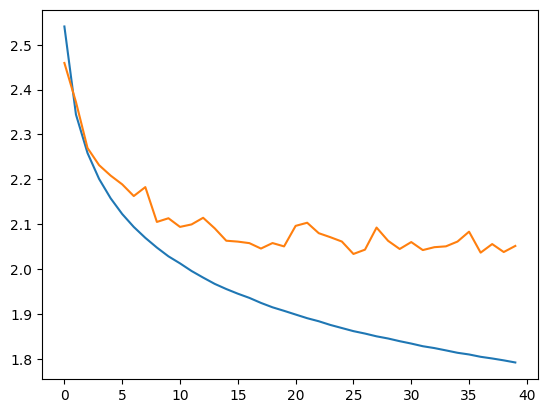

In [55]:
plt.plot(stepi, lossi)
plt.plot(stepi,lossvali)

In [56]:
model.eval()
loss_test=0
for x,y in test_loader:
      
  # forward pass
  logits=model(x)
  loss = F.cross_entropy(logits, y)
      
  loss_test+=loss
loss_test=loss_test/len(test_loader)
print(loss_test)

tensor(2.0132, grad_fn=<DivBackward0>)


On obtient un *loss* très correct et inférieur à celui du modèle Fully Connected avec un contexte de 8.

**Notes** : En regardant la courbe de validation par rapport à la courbe de training, on se rend compte qu'il y a peut-être un problème (et pareil avec le modèle Fully Connected de contexte 8). À vous de voir si vous arrivez à corriger ce problème avec ce que vous avez appris dans les cours précédents (voir [cours sur les réseaux fully connected](../02_RéseauFullyConnected/README.md)).


In [68]:
for _ in range(5):
  out = []
  context = [0] * block_size 
  while True:
    logits=model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

MARICE.
JEXE.
RAYEDE.
CHAHI.
RISHAE.


La génération de prénoms est de mieux en mieux !


**Exercice** : Pour vous entraîner, essayez de modifier les paramètres d'entraînement, l'architecture du réseau et autres pour obtenir un *loss* inférieur à 2.0 sur les données de test. Point bonus si vous réduisez le nombre de paramètres du modèle.
